# Дипломная работа: "Реальная стоимость недвижимости в Москве"

Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA
from datetime import datetime

%matplotlib inline

Выведем установленные пакеты

In [2]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


Пропишем путь к датасету

In [3]:
TRAIN_DATA_PATH = 'train.csv'
TEST_DATA_PATH = 'test.csv'

Откроем тренировочный датасет

In [4]:
df = pd.read_csv(TRAIN_DATA_PATH, sep=',')
df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


### EDA

**Корреляция**

Проверим, какие признаки сильно коррелируются. Для линейной модели линейная корреляция является проблемой.

C:\Users\Admin\AppData\Local\Temp\ipykernel_15532\1013707517.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = np.round(df.corr(), 2)


<Axes: >

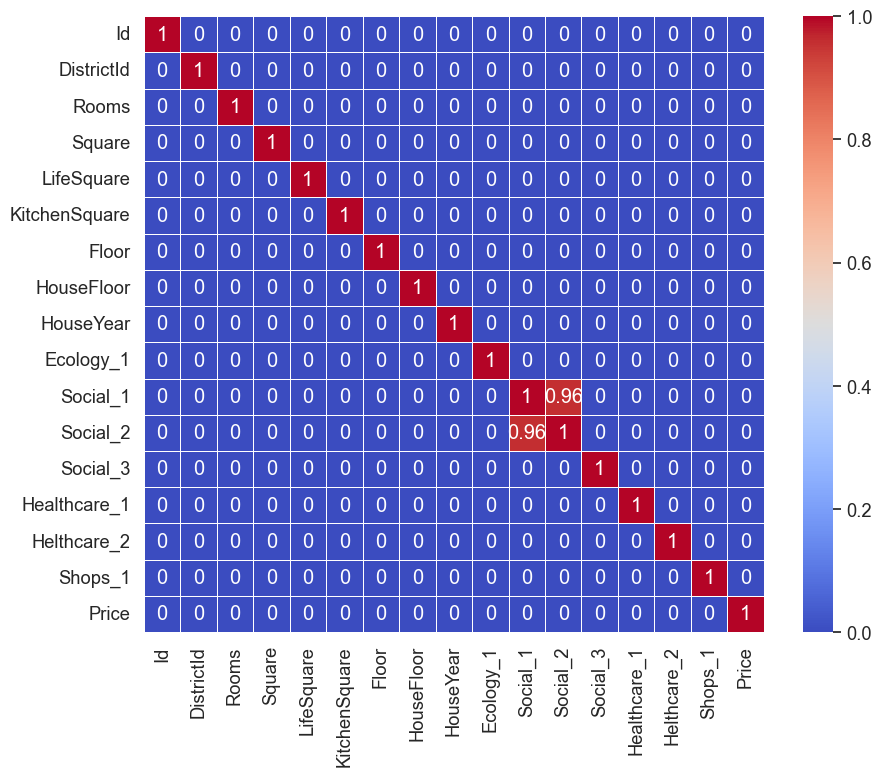

In [5]:
# Порог, после которого пара признаков считается сильно кореллирующей
high_correlation_threshold = 0.75

corr_matrix = np.round(df.corr(), 2)
corr_matrix[np.abs(corr_matrix) < high_correlation_threshold] = 0

plt.figure(figsize = (10,8))
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

Выведем пары сильно кореллирующих значений. Один признак из каждой пары удалим на этапе подготовки данных

In [6]:
for column in corr_matrix.columns:
    column_loc = corr_matrix.columns.get_loc(column)
    for row in range(len(corr_matrix.columns)):
        # После диагональной линии идет отзеркаленная часть,
        # не будем её рассматривать
        if column_loc == row:
            break
        if corr_matrix.iloc[row, column_loc] != 0:
            print(f"{column} {corr_matrix.columns[row]}")

Social_2 Social_1


### Подготовка данных

Изменим типы данных для сокращение потребляемой памяти

In [7]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 55.0%


Добавим функцию обнаружения выбросов по алгоритму Z-Score

In [9]:
def zscore(column):
    outliers = []
    threshold = 3.5
    mean = column.mean()
    std = column.std()
    for cell in column:
        z_score = (cell - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(cell)
    return outliers

Поделим данные на тренировочную и валидационную выборку

In [10]:
X = df.drop("Price", axis=1) # Признаки
y = df["Price"] # Целевая переменная

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

Подготовим данные

In [11]:
# Функции переведения количественных признаков в категориальные

def square_to_cat(X):
    bins = [20, 30, 40, 50, 75, X['Square'].max()]
    cat = pd.cut(X['Square'], bins=bins, labels=False)
    cat.fillna(-1, inplace=True)
    return cat


def year_to_cat(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    cat = pd.cut(X['HouseYear'], bins=bins, labels=False)
    cat.fillna(-1, inplace=True)
    return cat

class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
        self.cols_to_drop = None
        # Медиана, а не среднее арифметическое, потому что медиана не смещается из-за выбросов
        self.medians = None
        self.cols_with_missing = None
        self.initial = None
        
        # Районы и их медианы
        self.district_median_price_per_square = None
        self.district_median_square = None
        self.district_median_year = None
        self.district_median_price_per_square_median = None
        
        self.features_to_numbers = [
            "Ecology_2", "Ecology_3", "Shops_2"
        ]
        
        # Пары признаков на слияние
        self.merge_features = [
            ["Social_1", "Social_2"]
        ]
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
    def fit(self, df, y):
        """Сохранение статистик"""
        
        # Отметим столбцы с незаполненными ячейками
        
        self.cols_with_missing = [col for col in df.columns 
                                 if df[col].isnull().any()]
        
        # Скопируем нужные признаки из изначального состояния
        
        """self.initial = df.copy()
        for col in df.columns:
            if df[col].dtype == 'object' or col in self.cols_to_drop:
                self.initial.drop(col, axis=1, inplace=True)
        """
                
        self.initial = pd.DataFrame(None, columns=[col for col in df.columns
                                                   if df[col].dtype != 'object'])
        
        # Раcчитаем медианные значения
        
        self.medians = {}
        for col in self.initial.columns:
            self.medians[col] = df[col].median()
            
        # Расчитаем матрицу корреляции признаков
        """
        self.initial_corr = self.initial.corr()
        """
        
        # Временно переведем количественные признаки в
        # категориальные для дальнейшей группировки
        df_with_cats = df.copy()
        df_with_cats['SquareCategory'] = square_to_cat(df)
        df_with_cats['HouseYearCategory'] = year_to_cat(df)
        
        # Расчитаем медианные значения районов
        
        self.district_median_square = df_with_cats.groupby(['DistrictId'])['SquareCategory'].agg('median')
        self.district_median_year = df_with_cats.groupby(['DistrictId'])['HouseYearCategory'].agg('median')
        df_with_price = df.copy()
        df_with_price['Price'] = y
        self.district_median_price_per_square = df_with_price.groupby(['DistrictId'])['Price'].agg('median') \
            / self.district_median_square
        
        # И медианы медиан
        self.district_median_square_median = \
            self.district_median_square.median()
        self.district_median_year_median = \
            self.district_median_year.median()
        self.district_median_price_per_square_median = \
            self.district_median_price_per_square.median()
        
        # Опишем категориальный признак DistrictId самим собой
        self.district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        
        # Пропуски в LifeSquare можно особо обработать
        df['LifeSquare_was_missing'] = df['LifeSquare'].isnull()
        
        # Допустим, мы не знаем жилую прощадь, но мы знаем всю площадь и площадь кухни
        condition = (df['LifeSquare'].isna()) & \
                    (~df['Square'].isna()) & \
                    (~df['KitchenSquare'].isna())
        
        # Значит мы можем приблизительно вычислить жилую площадь отняв от всей площади кухню и несколько квадратных метров
        df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] - \
            df.loc[condition, 'KitchenSquare'] - 3
        
        for col in self.cols_with_missing:
            df[col + '_was_missing'] = df[col].isnull()
            df[col].fillna(self.medians[col], inplace=True)
            
            """ # Этот код понижает точность модели до 0.66
            
            corr_with = [i for i in range(len(self.initial_corr.columns))
                         if self.initial_corr.iloc[i, self.initial_corr.columns.to_list().index(col)] > 0.5]
            df_column_list = df.columns.to_list()
            
            for row in range(len(df[col])):
                values = [self.initial.iloc[row, i] for i in corr_with]
                values.append(self.medians[col])
                df.iloc[row, df_column_list.index(col)] = np.nanmean(np.asarray(values))
            """
        
        # 2. Выбросы
        
        # Общая схема обработки выбросов
        for col in self.initial.columns:
            outliers = zscore(df[col])
            df[col + '_outlier'] = 0
            df.loc[df[col].isin(outliers), col + '_outlier'] = 1
            df.loc[df[col].isin(outliers), col] = self.medians[col]
        
        # Индивидуальная схема обработки выбросов Rooms
        df.loc[(X['Rooms'] < 1), 'Rooms_outlier'] = 1
        df.loc[df['Rooms'] < 1, 'Rooms'] = 1
        
        # HouseYear
        current_year = datetime.now().year
        df.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        df.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # 3. Новые признаки
        
        # Перевод категориальных признаков в нули и единицы
        for feature in self.features_to_numbers:
            df[feature] = df[feature].replace(self.binary_to_numbers)
        
        # Feature Encoding
        df['DistrictPricePerSquare'] = df['DistrictId'].map(self.district_median_price_per_square)
        df['DistrictSquare'] = df['DistrictId'].map(self.district_median_square)
        df['DistrictYear'] = df['DistrictId'].map(self.district_median_year)
        
        # Некоторые значение могут быть не заполнены на валидационной и тестовой выборке
        df['DistrictPricePerSquare'].fillna(self.district_median_price_per_square_median, inplace=True)
        df['DistrictSquare'].fillna(self.district_median_square_median, inplace=True)
        df['DistrictYear'].fillna(self.district_median_year_median, inplace=True)
            
        # DistrictSize
        df = df.merge(self.district_size, on='DistrictId', how='left')
        df.drop("DistrictId", axis=1, inplace=True)
        
        # На тестовой выборке могут появиться новые районы для которых нету соответствия в DistrictSize.
        # Отметим их и заполним пятерками
        df['IsNewDistrict'] = 0
        df.loc[df['DistrictSize'].isna(), 'IsNewDistrict'] = 1
        df['DistrictSize'].fillna(5, inplace=True)
            
        # 4. Линейно кореллирующие признаки
        # Как показывает практика, их стоит удалять не только при использовании линейной модели
        
        pca = PCA(n_components=1, random_state=42)
        
        for corr_features in self.merge_features:
            df['_'.join(corr_features)] = pca.fit_transform(df[corr_features])
            df.drop(corr_features, axis=1, inplace=True)
        
        # 5. Удаление уникальных идентификаторов наблюдений
        
        df.drop('Id', axis=1, inplace=True)
        
        return df

In [12]:
pipe = DataPipeline()
pipe.fit(X_train, y_train)
X_train = pipe.transform(X_train)
X_valid = pipe.transform(X_valid)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15532\2178254550.py:173: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = df.merge(self.district_size, on='DistrictId', how='left')
C:\Users\Admin\AppData\Local\Temp\ipykernel_15532\2178254550.py:173: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = df.merge(self.district_size, on='DistrictId', how='left')


In [13]:
X_train.head(5)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3_outlier,Healthcare_1_outlier,Helthcare_2_outlier,Shops_1_outlier,DistrictPricePerSquare,DistrictSquare,DistrictYear,DistrictSize,IsNewDistrict,Social_1_Social_2
0,1.0,38.234364,20.008121,8.0,6,3.0,1977,0.000000,1,1,...,0,0,0,0,96614.541667,3.0,2.0,40.0,0,-1658.085937
1,1.0,31.309444,24.479166,5.0,1,5.0,1969,0.038693,1,1,...,0,0,0,0,102509.175781,2.0,2.0,88.0,0,1190.910077
2,2.0,47.234447,19.363581,6.0,2,12.0,1980,0.000000,1,1,...,0,0,0,0,107854.567708,3.0,4.0,18.0,0,5976.947685
3,3.0,63.841679,38.098614,8.0,9,12.0,1983,0.300323,1,1,...,0,0,0,0,75188.838542,3.0,3.0,81.0,0,4968.977388
4,1.0,36.054333,34.296082,1.0,15,17.0,2016,0.011654,1,1,...,0,0,0,0,48640.619792,3.0,2.0,594.0,0,-4427.141163


Визуализируем два корреллирующих признака. Где диагональная линия, там сильная корреляция. Хвостики - это заполненные пропущенные значения. Я пробовала их заполнить, но сильно понизила точность модели, поэтому закоментировала этот код

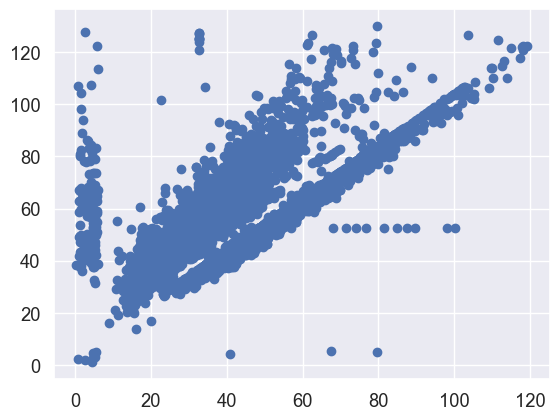

In [14]:
# ls_color = X_train["LifeSquare_was_missing"]
plt.scatter(x=X_train["LifeSquare"], y=X_train["Square"])
plt.show()

Перед обучением стандартизируем признаки (у меня с этим проблема: точность модели понижается до -2.5, поэтому я этого делать не буду)

In [15]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

### Обучение и предсказание

По сетке найдем наилучшую конфигурацию модели градиентного бустинга, используя кросс-валидацию

In [16]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(GradientBoostingRegressor(criterion='mse',
                                     min_samples_leaf=10,
                                     random_state=42),
                  params, # список возможных параметров
                  scoring='r2', # метрика качества 
                  cv=KFold(n_splits=5, # количество разбиений в кросс-валидации
                           random_state=42, 
                           shuffle=True), # перемешаем данные
                  n_jobs=-1) # используем все ядра процессора

# Я закометирую строчки с обучением, чтобы случайно не запустились.
# Обучение и кросс валидация очень долго длятся, а лучшие гиперпараметры уже извесны

# gs.fit(X_train, y_train)
# gs.best_params_ # получим наилучшие гиперпараметры

Посмотрим оценку кросс валидации наилучшей модели на тренировочных данных

In [17]:
# gs.best_score_

Создадим и обучим модель градиентного бустинга с конфигурацией (почти идеальной)

In [18]:
model = GradientBoostingRegressor(criterion='friedman_mse',
                                  max_depth=6,
                                  min_samples_leaf=50,
                                  random_state=42,  
                                  n_estimators=2250,
                                  learning_rate=0.025,
                                  max_features='sqrt',
                                  loss='huber')
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.025, loss='huber', max_depth=6,
                          max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=42)

Оценим точность модели на тренировочной и валидационной выборке. Заметно переобучение на 15%

In [19]:
print(f"Тренировочная выборка: {r2_score(model.predict(X_train), y_train)}")
print(f"Валидационная выборка: {r2_score(model.predict(X_valid), y_valid)}")

Тренировочная выборка: 0.8227090809180113
Валидационная выборка: 0.6738387081489456


Посмотрим, какой вес имеют признаки. Как видим, признаки, заканчивающиеся на _outlier не имеют вес, т.к. не имеют выбросов. IsNewDistrict тоже оказался бесполезным, поскольку новых районов в валидационной и тестовой выборке не оказалось.

In [20]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.230408
0,Rooms,0.142940
33,DistrictPricePerSquare,0.138040
36,DistrictSize,0.100753
2,LifeSquare,0.089668
3,KitchenSquare,0.051553
38,Social_1_Social_2,0.046846
10,Social_3,0.041101
6,HouseYear,0.032560
7,Ecology_1,0.020577


Загрузим тестовые данные и обработаем их

In [21]:
test_data = pd.read_csv(TEST_DATA_PATH, sep=',')

# Сохраним ID всех строк. DataPipeline удалит столбец Id, но все строки оставит
test_data_ids = test_data["Id"]

test_data = pipe.transform(test_data)
test_data.head(5)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15532\2178254550.py:173: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = df.merge(self.district_size, on='DistrictId', how='left')


,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3_outlier,Healthcare_1_outlier,Helthcare_2_outlier,Shops_1_outlier,DistrictPricePerSquare,DistrictSquare,DistrictYear,DistrictSize,IsNewDistrict,Social_1_Social_2
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,0,0,0,103412.156250,2.0,2.0,73.0,0,-1028.894976
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,53330.828125,3.0,2.0,173.0,0,-4777.954067
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,0,0,0,0,48640.619792,3.0,2.0,594.0,0,-3514.935873
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,0,0,37971.708333,3.0,2.0,390.0,0,-4931.952734
4,1.0,53.837056,49.837056,1.0,8,17.0,1977,0.309479,1,1,...,0,0,0,0,61214.244792,3.0,2.0,79.0,0,2308.121905


Предскажем цену на недвижимость на этих данных

In [22]:
test_pred = model.predict(test_data)
test_pred

array([164696.49012622, 121487.90264591, 135752.80498479, ...,
       152393.75630495, 188279.83089699, 306600.18164513])

Преобразуем в формат

In [23]:
test_pred_output = pd.DataFrame({"Id": test_data_ids, "Price": test_pred})
test_pred_output.head()

,Id,Price
0,4567,164696.490126
1,5925,121487.902646
2,960,135752.804985
3,3848,111865.871798
4,746,187433.036107


Сохраним предсказания в файл

In [24]:
test_pred_output.to_csv("submission.csv", index=False)